# Wilson's Morning Wake Up Playlist Generator, Feature Engineering

This notebook is broken down into the following tasks:

* Clean and pre-process the data.
* Standardization and normalization of numerical variables
* Define features for harmonic sequencing
* Create train/test `.csv` files that hold the relevant features and class labels for train/test data points

In the _next_ notebook, Train_Deploy , we will use the features and `.csv` files created in _this_ notebook to train an estimator in a SageMaker notebook instance.

In [1]:
# Import librariess
import pandas as pd
import numpy as np
import os
import pickle
from pickle import dump
import joblib
import random

This Wilson Morning Wake Up dataset is summarized in a `.csv` file named `wmw_tracks.csv`, which we can read in using `pandas`. This was created in the Explore notebook.

In [2]:
# Read file
csv_file = 'data/wmw_tracks.csv'
wmw_df = pd.read_csv(csv_file)
wmw_df.head()

,volume,position,track_name,artist_name,danceability,energy,key,loudness,mode,speechiness,...,liveness,valence,tempo,type,id,uri,track_href,analysis_url,duration_ms,time_signature
0,38,1,Finding It There,Goldmund,0.187,0.00257,1,-37.134,1,0.0427,...,0.0915,0.0374,123.707,audio_features,6CnPCuUcM3A5PMP4gUy0vw,spotify:track:6CnPCuUcM3A5PMP4gUy0vw,https://api.spotify.com/v1/tracks/6CnPCuUcM3A5...,https://api.spotify.com/v1/audio-analysis/6CnP...,220120,5
1,38,2,Light Forms,Rohne,0.671,0.54500,10,-12.848,0,0.0393,...,0.1180,0.2840,133.036,audio_features,6MkUPsz5hYeneo0a9H0VT8,spotify:track:6MkUPsz5hYeneo0a9H0VT8,https://api.spotify.com/v1/tracks/6MkUPsz5hYen...,https://api.spotify.com/v1/audio-analysis/6MkU...,265870,4
2,38,3,C-Side,Khruangbin,0.688,0.77900,11,-10.129,0,0.0579,...,0.3490,0.9380,94.073,audio_features,6GvAM8oyVApQHGMgpBt8yl,spotify:track:6GvAM8oyVApQHGMgpBt8yl,https://api.spotify.com/v1/tracks/6GvAM8oyVApQ...,https://api.spotify.com/v1/audio-analysis/6GvA...,283407,4
3,38,4,Didn't I (Dave Allison Rework),Darondo,0.539,0.70500,0,-6.729,1,0.0527,...,0.1330,0.6850,186.033,audio_features,1owjOeZt1BdYWW6T8fIAEe,spotify:track:1owjOeZt1BdYWW6T8fIAEe,https://api.spotify.com/v1/tracks/1owjOeZt1BdY...,https://api.spotify.com/v1/audio-analysis/1owj...,328000,4
4,38,5,Woman Of The Ghetto - Akshin Alizadeh Remix,Marlena Shaw,0.707,0.57300,7,-8.403,0,0.0276,...,0.0858,0.1890,100.006,audio_features,2h8cQH7zhUWrynZi2MKhhC,spotify:track:2h8cQH7zhUWrynZi2MKhhC,https://api.spotify.com/v1/tracks/2h8cQH7zhUWr...,https://api.spotify.com/v1/audio-analysis/2h8c...,302467,4


In [3]:
# Show duplicated songs - woops!
wmw_df[wmw_df.duplicated(['track_name', 'artist_name'], keep=False)].sort_values('track_name')

,volume,position,track_name,artist_name,danceability,energy,key,loudness,mode,speechiness,...,liveness,valence,tempo,type,id,uri,track_href,analysis_url,duration_ms,time_signature
540,3,15,4AM,Vessels,0.482,0.794,0,-10.800,0,0.0442,...,0.1070,0.0382,150.036,audio_features,4MCL9tV2X5OiwT1oIl9pqK,spotify:track:4MCL9tV2X5OiwT1oIl9pqK,https://api.spotify.com/v1/tracks/4MCL9tV2X5Oi...,https://api.spotify.com/v1/audio-analysis/4MCL...,395229,4
466,8,15,4AM,Vessels,0.482,0.794,0,-10.800,0,0.0442,...,0.1070,0.0382,150.036,audio_features,77HWONgBl3FZbXarvXfRjc,spotify:track:77HWONgBl3FZbXarvXfRjc,https://api.spotify.com/v1/tracks/77HWONgBl3FZ...,https://api.spotify.com/v1/audio-analysis/77HW...,395229,4
192,26,10,Always Like This - Andhim Remix,HVOB,0.793,0.480,1,-12.183,0,0.0829,...,0.4690,0.2480,122.030,audio_features,7qfLlPC8tlohz2QYwGqkJW,spotify:track:7qfLlPC8tlohz2QYwGqkJW,https://api.spotify.com/v1/tracks/7qfLlPC8tloh...,https://api.spotify.com/v1/audio-analysis/7qfL...,359016,4
207,25,10,Always Like This - Andhim Remix,HVOB,0.793,0.480,1,-12.183,0,0.0829,...,0.4690,0.2480,122.030,audio_features,7qfLlPC8tlohz2QYwGqkJW,spotify:track:7qfLlPC8tlohz2QYwGqkJW,https://api.spotify.com/v1/tracks/7qfLlPC8tloh...,https://api.spotify.com/v1/audio-analysis/7qfL...,359016,4
199,25,2,Anchor (feat. Ishmael),Laurence Guy,0.706,0.640,11,-12.578,1,0.0416,...,0.0915,0.5750,121.024,audio_features,2FVgIrE55fd4ktm86pfhFx,spotify:track:2FVgIrE55fd4ktm86pfhFx,https://api.spotify.com/v1/tracks/2FVgIrE55fd4...,https://api.spotify.com/v1/audio-analysis/2FVg...,287666,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
65,34,6,U,DJ Seinfeld,0.721,0.838,8,-7.579,1,0.0428,...,0.0445,0.4530,125.999,audio_features,2tYctbOGPK2OZ2g2wKipgj,spotify:track:2tYctbOGPK2OZ2g2wKipgj,https://api.spotify.com/v1/tracks/2tYctbOGPK2O...,https://api.spotify.com/v1/audio-analysis/2tYc...,368000,4
354,15,8,Underworld,Edu Imbernon,0.878,0.482,8,-11.166,1,0.0483,...,0.0701,0.2970,123.023,audio_features,2gGeFW6SBAG5K5SNIQ4LW4,spotify:track:2gGeFW6SBAG5K5SNIQ4LW4,https://api.spotify.com/v1/tracks/2gGeFW6SBAG5...,https://api.spotify.com/v1/audio-analysis/2gGe...,425463,4
505,5,11,Underworld,Edu Imbernon,0.862,0.542,8,-10.615,1,0.0449,...,0.1070,0.3230,122.991,audio_features,2T0QyKXxEGsEGkY31deDam,spotify:track:2T0QyKXxEGsEGkY31deDam,https://api.spotify.com/v1/tracks/2T0QyKXxEGsE...,https://api.spotify.com/v1/audio-analysis/2T0Q...,320000,4
183,26,1,Vates,Otto Totland,0.360,0.231,4,-26.701,0,0.0336,...,0.0878,0.2820,104.094,audio_features,5lfBUkuT4mprXGQML18tyq,spotify:track:5lfBUkuT4mprXGQML18tyq,https://api.spotify.com/v1/tracks/5lfBUkuT4mpr...,https://api.spotify.com/v1/audio-analysis/5lfB...,256725,4


In [4]:
wmw_df.columns

Index(['volume', 'position', 'track_name', 'artist_name', 'danceability',
       'energy', 'key', 'loudness', 'mode', 'speechiness', 'acousticness',
       'instrumentalness', 'liveness', 'valence', 'tempo', 'type', 'id', 'uri',
       'track_href', 'analysis_url', 'duration_ms', 'time_signature'],
      dtype='object')

In [5]:
# HOLD ON to duplicates
# print("Initial shape:", wmw_df.shape[0], 'tracks')
# wmw_df.drop_duplicates(subset=['track_name', 'artist_name'], inplace=True)
# print("New shape:", wmw_df.shape[0], 'tracks')

In [6]:
# Exclude unnecessary columns
exclude_cols = ['track_name', 'artist_name', 'duration_ms', 'track_href', 'uri', 'time_signature', 'id', 'type', 'analysis_url', 'mode','key']

wmw_df.drop(columns=exclude_cols, inplace=True)

In [7]:
# Feature list
feature_list = ['danceability','energy', 'loudness', 'speechiness', 'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo']

# Hold out: 'mode','key','tempo'

# Output list
output_list = ['danceability','energy', 'loudness', 'speechiness', 'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo']

---
## Standardise features

In [8]:
from sklearn.preprocessing import StandardScaler

# Standardize features
standard_scaler = StandardScaler()

standard_scaler.fit(wmw_df[feature_list])

standard_features = standard_scaler.transform(wmw_df[feature_list])

processed_df = pd.DataFrame(standard_features, index=wmw_df.index, columns=wmw_df.columns[2:])

wmw_df = pd.concat([wmw_df[['volume', 'position']],processed_df[feature_list]], axis=1)

wmw_df.head(10)

,volume,position,danceability,energy,loudness,speechiness,acousticness,instrumentalness,liveness,valence,tempo
0,38,1,-2.436270,-2.689936,-5.537915,-0.285038,2.178734,0.930039,-0.489164,-1.177384,0.228194
1,38,2,0.265261,-0.153167,-0.399305,-0.361503,0.743475,0.641374,-0.288810,-0.138053,0.677673
2,38,3,0.360149,0.941175,0.176001,0.056805,-0.738506,-1.501747,1.457674,2.618325,-1.199598
3,38,4,-0.471520,0.595101,0.895398,-0.060141,-0.831401,-1.452178,-0.175402,1.552020,3.231114
4,38,5,0.466201,-0.022220,0.541201,-0.624632,-0.780342,-0.997312,-0.532259,-0.538444,-0.913741
5,38,6,0.672723,1.203068,0.097290,-0.055643,0.364811,0.810491,-0.756051,-0.087477,-0.046919
6,38,7,0.549926,1.034708,0.641281,0.391902,-0.007745,0.731764,-0.273689,0.237050,2.453186
7,38,8,1.281126,-0.831285,0.568072,0.670774,1.271773,0.238992,-0.589719,-1.100678,0.772541
8,38,9,-0.426867,0.010516,0.605523,-0.172590,0.276253,-1.425936,0.391639,-0.184414,-2.068925
9,38,10,0.360149,0.342560,0.039527,-0.489694,0.282360,-0.577435,-0.409778,-0.163341,0.145323


In [9]:
wmw_df.shape

(569, 11)

In [10]:
# Save the scaler
# dump(standard_scaler, open('utilities/standard_features.pkl', 'wb'))

---
## Fit PCA for track selection in post-processing

In [11]:
from sklearn.decomposition import PCA

pca = PCA(n_components=3)

pca.fit(wmw_df[feature_list])

print(pca.explained_variance_ratio_)

print(pca.singular_values_)

[0.3551389  0.13650023 0.12164728]
[42.6458239  26.43894275 24.95908092]


In [12]:
pca_df = pca.transform(wmw_df[feature_list])

In [13]:
import matplotlib.pyplot as plt, numpy as np
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(pca_df[:,0], pca_df[:,1], pca_df[:,2])
plt.show()

<Figure size 640x480 with 1 Axes>

In [14]:
# Save PCA
# dump(pca, open('artefacts/dim_red.pkl', 'wb'))

---
## Prepare inputs and target features for training

Given the playlists variable-length sequences, it will only take the first 12 tracks of each volume. In the future, the model will account for variable-length inputs using padding.

In [15]:
# Prepare labels using shift
training_df = pd.DataFrame()

for i in wmw_df['volume'].unique():
    X_df = wmw_df[wmw_df['volume'] == i].iloc[:13]
    y_df = wmw_df[wmw_df['volume'] == i].iloc[:13].shift(-1)[output_list]
    X_y_df = pd.concat([X_df, y_df.add_prefix('y_')], axis=1).dropna()
    training_df = training_df.append(X_y_df, ignore_index=True)
    
    # Clean up
    del X_df
    del y_df
    del X_y_df

In [16]:
training_df.shape

(456, 20)

In [17]:
training_df.columns

Index(['volume', 'position', 'danceability', 'energy', 'loudness',
       'speechiness', 'acousticness', 'instrumentalness', 'liveness',
       'valence', 'tempo', 'y_danceability', 'y_energy', 'y_loudness',
       'y_speechiness', 'y_acousticness', 'y_instrumentalness', 'y_liveness',
       'y_valence', 'y_tempo'],
      dtype='object')

In [18]:
training_df.head()

,volume,position,danceability,energy,loudness,speechiness,acousticness,instrumentalness,liveness,valence,tempo,y_danceability,y_energy,y_loudness,y_speechiness,y_acousticness,y_instrumentalness,y_liveness,y_valence,y_tempo
0,38,1,-2.436270,-2.689936,-5.537915,-0.285038,2.178734,0.930039,-0.489164,-1.177384,0.228194,0.265261,-0.153167,-0.399305,-0.361503,0.743475,0.641374,-0.288810,-0.138053,0.677673
1,38,2,0.265261,-0.153167,-0.399305,-0.361503,0.743475,0.641374,-0.288810,-0.138053,0.677673,0.360149,0.941175,0.176001,0.056805,-0.738506,-1.501747,1.457674,2.618325,-1.199598
2,38,3,0.360149,0.941175,0.176001,0.056805,-0.738506,-1.501747,1.457674,2.618325,-1.199598,-0.471520,0.595101,0.895398,-0.060141,-0.831401,-1.452178,-0.175402,1.552020,3.231114
3,38,4,-0.471520,0.595101,0.895398,-0.060141,-0.831401,-1.452178,-0.175402,1.552020,3.231114,0.466201,-0.022220,0.541201,-0.624632,-0.780342,-0.997312,-0.532259,-0.538444,-0.913741
4,38,5,0.466201,-0.022220,0.541201,-0.624632,-0.780342,-0.997312,-0.532259,-0.538444,-0.913741,0.672723,1.203068,0.097290,-0.055643,0.364811,0.810491,-0.756051,-0.087477,-0.046919


---
## Save tensor friendly data for Deep Learning

In [19]:
import torch

tracks = torch.from_numpy(training_df[output_list].values)

In [20]:
tracks.shape

torch.Size([456, 9])

In [21]:
tracks.shape, tracks.stride()

(torch.Size([456, 9]), (1, 456))

In [22]:
playlist_tracks = tracks.view(-1, 12, tracks.shape[1])
playlist_tracks.shape, playlist_tracks.stride()

(torch.Size([38, 12, 9]), (12, 1, 456))

In [23]:
training_df.to_csv("data/tensor_train.csv", index=False)

---
## Quick look at the results

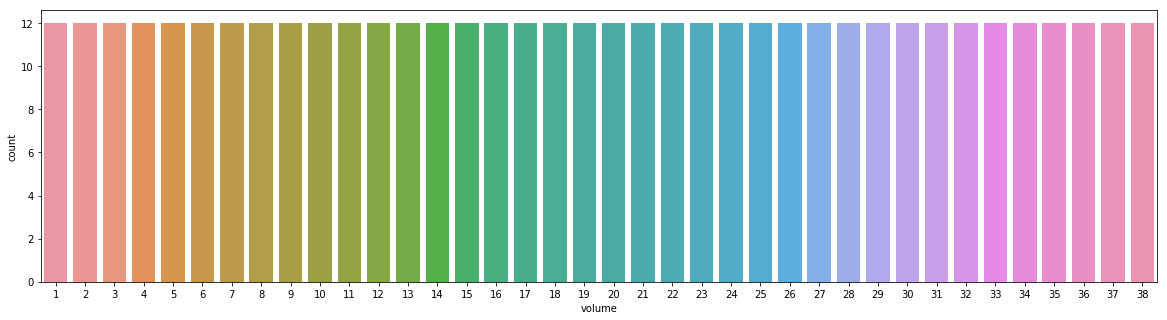

In [24]:
%matplotlib inline

import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(20,5))

ax = sns.countplot(x="volume", data=training_df)

# training_df.plot.bar(x='volume', rot=0)

---
## Save data for traditional Machine Learning 

Not of use for now.

In [25]:
# def make_csv(x, filename, data_dir):
#     '''Merges features and labels and converts them into one csv file with labels in the first column.
#        :param x: Data features
#        :param y: Data labels
#        :param file_name: Name of csv file, ex. 'train.csv'
#        :param data_dir: The directory where files will be saved
#        '''
#     # make data dir, if it does not exist
#     if not os.path.exists(data_dir):
#         os.makedirs(data_dir)
    
#     data = pd.DataFrame(x).dropna()
#     data.to_csv(os.path.join(data_dir, filename), index=False)
    
#     # nothing is returned, but a print statement indicates that the function has run
#     print('Path created: '+str(data_dir)+'/'+str(filename))

In [26]:
# # Can change directory, if you want
# data_dir = 'data'

# make_csv(wmw_df, filename='wmw.csv', data_dir=data_dir)

In [27]:
# # Can change directory, if you want
# data_dir = 'data'

# make_csv(training_df, filename='train.csv', data_dir=data_dir)

In [28]:
# training_df.iloc[:, 2:10].head()

In [29]:
# training_df.iloc[:, 11:].head()

In [30]:
# # Build sequences and targets
# def create_playlist_sequences(input_data):
#     input_playlists = []
    
#     for i in input_data['volume'].unique():
#         temp_vol = input_data[input_data['volume'] == i]
#         X = temp_vol.iloc[:, 2:10].values
#         y = temp_vol.iloc[:, 10:].values
#         input_playlists.append((X, y))
        
#     return input_playlists

In [31]:
# # Gather sequences and targets
# processed_data = create_playlist_sequences(training_df)

# # Take a look at first input and target
# print("X", processed_data[0][0][0])
# print("y", processed_data[0][1][0])

In [32]:
# from unittest.mock import MagicMock, patch

# def _print_success_message():
#     print('Tests Passed!')

# def test_playlist_sequences(input_playlists):
    
#     track_features = [-2.39099487, -2.63509459, -0.27732204,  0.92969533, -0.48983686,-1.15691947,  1.08569029, -1.20454903,  2.09618458]
    
#     track_features_len = 9
#     target_features_len = 8
    
#     # check shape and equality of first track
#     assert len(input_playlists[0][0][0]) == len(track_features), \
#         'Number of features in input_playlist features does not match expected number of ' + str(len(track_features))    
    
#     # check shape of input and output arrays
#     assert input_playlists[0][0].shape[1]==track_features_len, \
#         'input_features should have as many columns as selected features, got: {}'.format(train_x.shape[1])
#     assert input_playlists[0][1].shape[1]==target_features_len, \
#         'target_features should have as many columns as selected features, got: {}'.format(train_x.shape[1])
    
#     #TODO: Add more tests
    
#     _print_success_message()

In [33]:
# Test processed sequences
# test_playlist_sequences(processed_data)

---
## Visualise processed features

In [34]:
# Read file
csv_file = 'data/wmw_tracks.csv'
df = pd.read_csv(csv_file)
df.head()

,volume,position,track_name,artist_name,danceability,energy,key,loudness,mode,speechiness,...,liveness,valence,tempo,type,id,uri,track_href,analysis_url,duration_ms,time_signature
0,38,1,Finding It There,Goldmund,0.187,0.00257,1,-37.134,1,0.0427,...,0.0915,0.0374,123.707,audio_features,6CnPCuUcM3A5PMP4gUy0vw,spotify:track:6CnPCuUcM3A5PMP4gUy0vw,https://api.spotify.com/v1/tracks/6CnPCuUcM3A5...,https://api.spotify.com/v1/audio-analysis/6CnP...,220120,5
1,38,2,Light Forms,Rohne,0.671,0.54500,10,-12.848,0,0.0393,...,0.1180,0.2840,133.036,audio_features,6MkUPsz5hYeneo0a9H0VT8,spotify:track:6MkUPsz5hYeneo0a9H0VT8,https://api.spotify.com/v1/tracks/6MkUPsz5hYen...,https://api.spotify.com/v1/audio-analysis/6MkU...,265870,4
2,38,3,C-Side,Khruangbin,0.688,0.77900,11,-10.129,0,0.0579,...,0.3490,0.9380,94.073,audio_features,6GvAM8oyVApQHGMgpBt8yl,spotify:track:6GvAM8oyVApQHGMgpBt8yl,https://api.spotify.com/v1/tracks/6GvAM8oyVApQ...,https://api.spotify.com/v1/audio-analysis/6GvA...,283407,4
3,38,4,Didn't I (Dave Allison Rework),Darondo,0.539,0.70500,0,-6.729,1,0.0527,...,0.1330,0.6850,186.033,audio_features,1owjOeZt1BdYWW6T8fIAEe,spotify:track:1owjOeZt1BdYWW6T8fIAEe,https://api.spotify.com/v1/tracks/1owjOeZt1BdY...,https://api.spotify.com/v1/audio-analysis/1owj...,328000,4
4,38,5,Woman Of The Ghetto - Akshin Alizadeh Remix,Marlena Shaw,0.707,0.57300,7,-8.403,0,0.0276,...,0.0858,0.1890,100.006,audio_features,2h8cQH7zhUWrynZi2MKhhC,spotify:track:2h8cQH7zhUWrynZi2MKhhC,https://api.spotify.com/v1/tracks/2h8cQH7zhUWr...,https://api.spotify.com/v1/audio-analysis/2h8c...,302467,4


In [35]:
# Setup feature standardisation
std_scaler = joblib.load('artefacts/standard_features.pkl')

# Setup dimensionality reduction for track picking
dim_red = joblib.load('artefacts/dim_red.pkl')

In [36]:
# Prepare labels using shift
pca_df = pd.DataFrame()

for i in df['volume'].unique():
    X_df = df[df['volume'] == i].iloc[:13]
    y_df = df[df['volume'] == i].iloc[:13].shift(-1)[output_list]
    X_y_df = pd.concat([X_df, y_df.add_prefix('y_')], axis=1).dropna()
    pca_df = pca_df.append(X_y_df, ignore_index=True)
    
    # Clean up
    del X_df
    del y_df
    del X_y_df

In [37]:
# Features
track_features = ['danceability', 'energy', 'loudness', 'speechiness', 
                  'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo']

pca_df[track_features] = std_scaler.transform(pca_df[track_features])

coordinates = dim_red.transform(pca_df[track_features])

In [38]:
pca_df = pd.concat([pca_df[['position', 'volume', 'track_name']], pd.DataFrame(coordinates, columns=['one_comp', 'two_comp', 'third_comp'])], axis=1)

In [39]:
pca_df.describe()

,position,volume,one_comp,two_comp,third_comp
count,456.000000,456.0000,456.000000,456.000000,456.000000
mean,6.500000,19.5000,-118.952595,-12.279041,0.356762
std,3.455844,10.9779,1.068870,1.134822,1.002846
min,1.000000,1.0000,-122.015894,-14.167121,-1.041007
25%,3.750000,10.0000,-119.400548,-12.986981,-0.495391
50%,6.500000,19.5000,-118.850262,-12.541121,0.078420
75%,9.250000,29.0000,-118.650327,-11.909952,1.101120
max,12.000000,38.0000,-115.196505,-6.543770,2.890251


### Analyse the variance of tracks at each track position

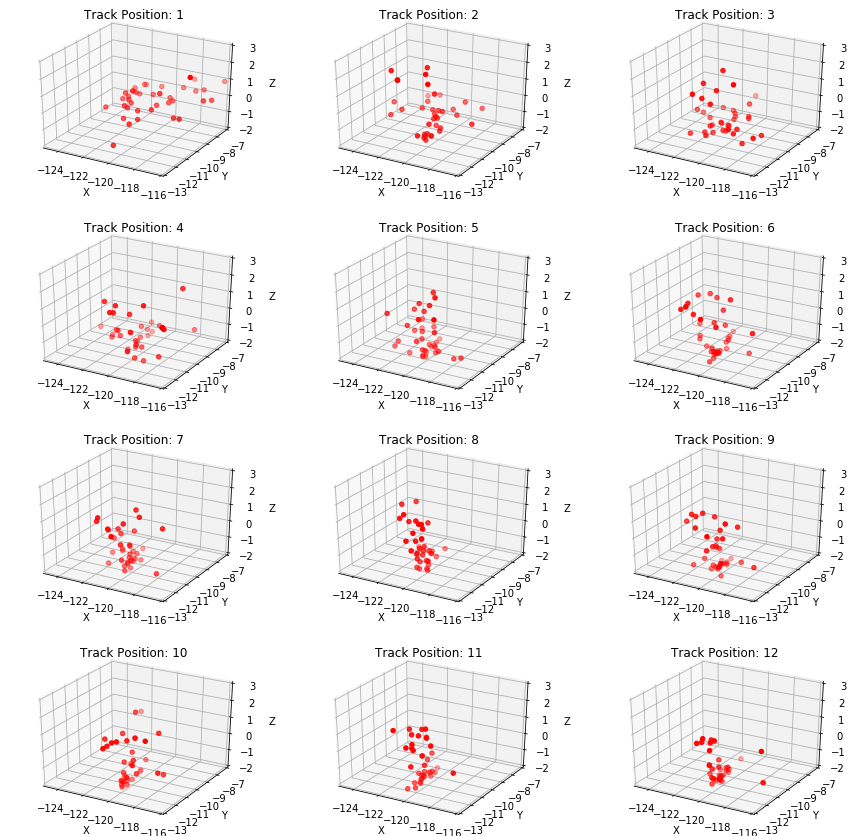

In [40]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import numpy as np

# Create figure outside the loop
fig = plt.figure(figsize=(15,15))

for i in range(1, len(pca_df['position'].unique().tolist()) + 1):

    # Add the i+1 subplot of the x.shape[0] x 1 grid
    ax = fig.add_subplot(4, 3, i, projection='3d')
    ax.set_title("Track Position: " + str(i))
    temp_df = pca_df[pca_df['position'] == i]
    ax.scatter(temp_df['one_comp'], temp_df['two_comp'], temp_df['third_comp'], c='r', marker='o')

    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')
    
    ax.set_xlim(-125, -116)
    ax.set_ylim(-13, -7)
    ax.set_zlim(-2, 3)
    
    
# Show it outside the loop
plt.show()

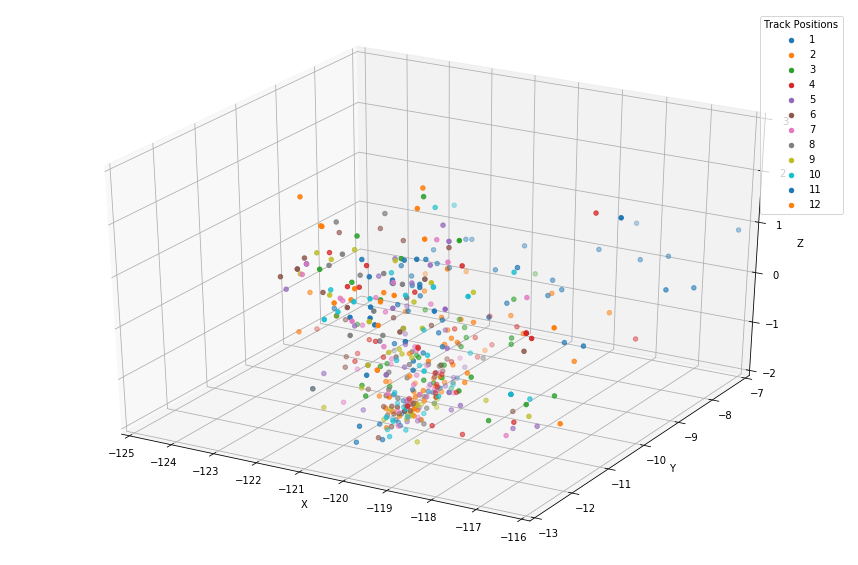

In [41]:
# Create figure outside the loop
fig = plt.figure(figsize=(15, 10))

# plot Economic Need Index vs School Income Estimate by group
groups = pca_df.groupby('position')

ax = fig.add_subplot(1, 1, 1, projection='3d')
# ax.set_title("Wilson Morning's Wake Up Tracks by Position")

for label, group in groups:
    ax.scatter(group['one_comp'], group['two_comp'], group['third_comp'], label=label)

ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')

ax.set_xlim(-125, -116)
ax.set_ylim(-13, -7)
ax.set_zlim(-2, 3)


ax.legend(title='Track Positions')

    
# Show it outside the loop
plt.show()

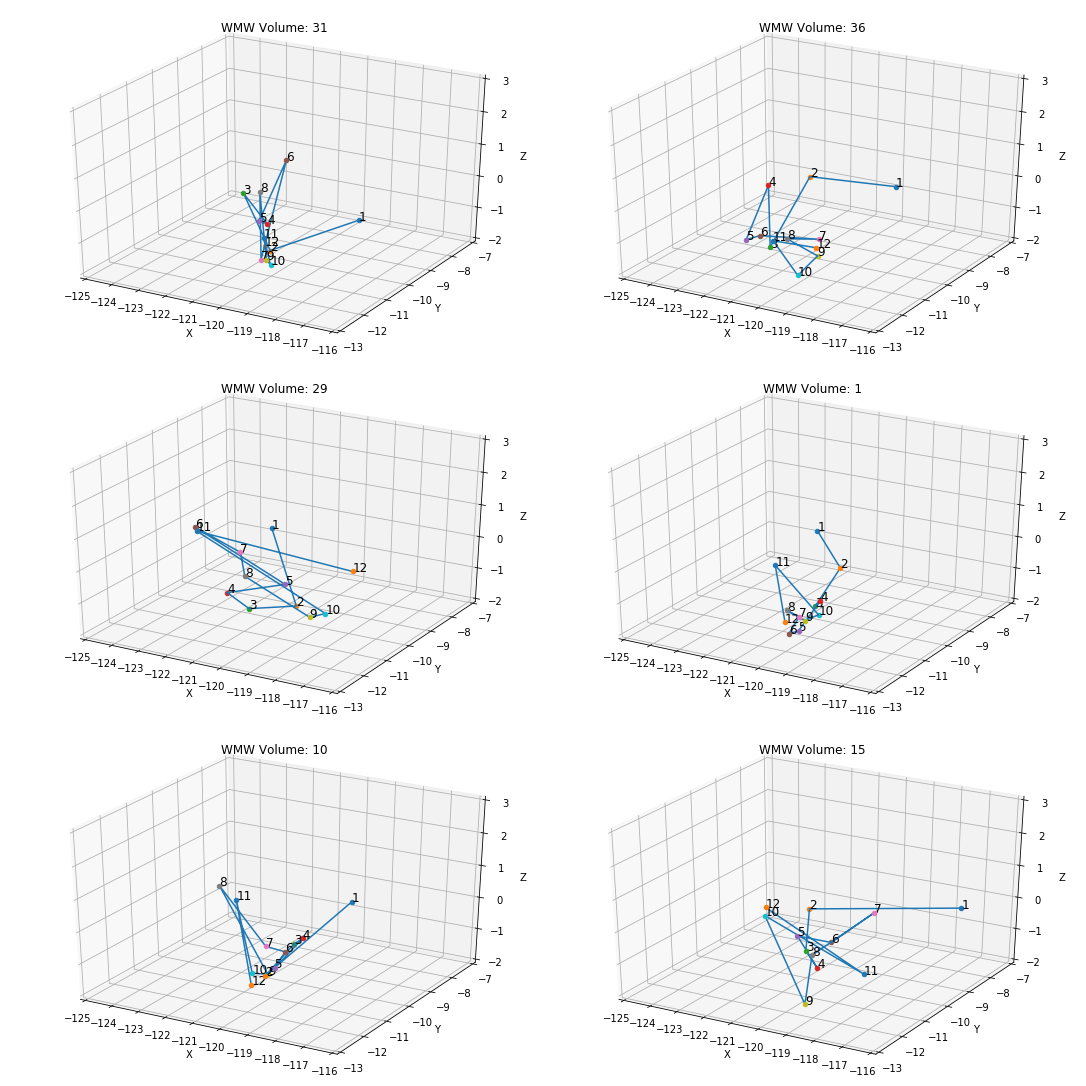

In [42]:
# Create figure outside the loop
fig = plt.figure(figsize=(15,15))

# random_volumes = random.randint(, 6)
random_volumes = random.sample(range(0, len(pca_df['volume'].unique().tolist())), 6)


for i in range(len(random_volumes)):

    # Add the i+1 subplot of the x.shape[0] x 1 grid
    ax = fig.add_subplot(3, 2, i+1, projection='3d')
    ax.set_title("WMW Volume: " + str(random_volumes[i]))
    temp_df = pca_df[pca_df['volume'] == random_volumes[i]]
    
    for i in range(len(temp_df)):
        x, y, z = temp_df.iloc[i]['one_comp'], temp_df.iloc[i]['two_comp'], temp_df.iloc[i]['third_comp']
        ax.scatter(x, y, z)
        ax.text(x, y, z, '{0}'.format(temp_df.iloc[i]['position']), size=12)
    
    ax.plot(temp_df['one_comp'], temp_df['two_comp'], temp_df['third_comp'])
    
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')
    
    ax.set_xlim(-125, -116)
    ax.set_ylim(-13, -7)
    ax.set_zlim(-2, 3)
    
plt.tight_layout(pad=0.4, w_pad=0.5, h_pad=1.0)

# Show it outside the loop
plt.show()